In [6]:
import pandas as pd
# import pyarrow.parquet as pq
from glob import glob
import ahocorasick
from Bio import SeqIO
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
gca_validate_res = pd.read_table("/mnt/nfs/wangd/project/10154parquet/res/spectrumAI/all_GCA_valiadate_out.tsv")

In [8]:
gca_validate_res

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,sum.supportions.intensity,flanking_ions_support,flanking_ions,sum.flanking.ions.intensity,matched_ions,sum.matchedions.intensity,sum.fragmentions.intensity,maxintensity,average_intensity,median_intensity
0,ALLEGESNPEIVIWAEHIENMPSEFR,GCA_171427,[313],[338],0.000556,1,['8-UNIMOD:7'],6139.0,3,1004.828918,...,5424.297363,NO,NaN,0.000000,"b3,b4,y5,y12,y13",19431.125000,1.420868e+05,14834.776367,5074.530273,2864.845703
1,SMGSKEDLIWELLNQAQEHFGK,GCA_181600,[274],[295],0.000556,1,['2-UNIMOD:35' '14-UNIMOD:7'],5621.1,4,645.313949,...,0.000000,NO,NaN,0.000000,"y2,b2,y3,y4,y5,y6,y7,y8",176022.937500,1.215564e+06,56165.175781,7150.376465,3683.201416
2,DVGEWQHEEFYR,GCA_227150,[305],[316],0.000556,1,NaN,2782.0,2,798.354431,...,2190.888916,NO,b2,2689.917236,"y1,b2,b4,y4,y5,y6,y7,y8",28311.791016,1.445844e+05,22369.044922,4252.482422,2313.378906
3,LLNLLADLVER,GCA_168207,[104],[114],0.000556,1,NaN,6258.8,2,634.884277,...,12204.037109,YES,"y7,b4,b3,y8",33771.050781,"y1,b2,b3,b4,y5,y6,y7,y8,y9",70609.812500,2.927408e+05,33524.777344,5629.630859,2589.843018
4,VLEMTGNIDETEWEWK,GCA_162724,[557],[572],0.000556,1,NaN,4556.1,2,990.460021,...,15181.633057,NO,y5,2300.426025,"b2,y2,b3,y4,y5,y8,y11,y12",30067.097656,7.241734e+04,8992.703125,3017.388916,2341.654297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134614,MVHLTPVEKSAVTALWGKVNVDEVGGEALGR,GCA_195928,[1],[31],0.000556,1,['0-UNIMOD:1'],5149.1,3,1102.561340,...,0.000000,NO,NaN,0.000000,"y1,y2,y4,y7,y8,y9,y10,y11,y12,y13,y15",196562.046875,5.019112e+06,583439.250000,29698.890625,11760.503906
134615,MGTPVLEALGDGEFVK,GCA_260523,[176],[191],0.000556,1,NaN,5237.3,2,832.431335,...,400644.178223,YES,"y7,b8,y8,b9",158911.046875,"y1,b2,y2,b3,y3,b5,y4,y5,b6,y6,b7,y7,b8,y8,b9,y...",684696.625000,2.556515e+06,98870.000000,11673.584961,4779.719727
134616,DIQNMNFLLKAEVQKLQALANEQAAAAHQLEK,GCA_302792,[639],[670],0.000556,1,['14|29-UNIMOD:7'],6078.3,4,895.723083,...,46776.661133,NO,NaN,0.000000,"y1,b2,b3,b4,b5,y6,y7,y8,y9,y10",72686.656250,8.544083e+05,59814.476562,6946.409180,4314.445312
134617,AGALNSNDAFVLKTPSAAYLWVGTGASEAEKMGAQELLR,GCA_170374,[585],[623],0.000556,1,['5|7|35-UNIMOD:7'],5424.9,4,1011.025024,...,12058.218750,YES,"y7,y8",15308.806641,"b2,y1,b3,b4,y7,y8",75547.062500,3.069368e+06,108006.968750,13230.037109,6523.543945


In [4]:
def to_set(x):
    return set(x.to_list())

### Before DeepLC+ms2pip

#### SpectrumAI

In [5]:
before_saav = gca_validate_res[gca_validate_res["position"].str.isdigit()]
before_novel = gca_validate_res[gca_validate_res["position"]=="non-canonical"]
before_saav_spectrumAI = before_saav[before_saav["flanking_ions_support"]=="YES"]

In [6]:
before_all_set = to_set(gca_validate_res["sequence"])
before_saav_set = to_set(before_saav["sequence"])
before_novel_set = to_set(before_novel["sequence"])
before_saav_spectrumAI_set =  to_set(before_saav_spectrumAI["sequence"])
before_all_spectrumAI_set = before_saav_spectrumAI_set.union(before_novel_set)

In [7]:
print("----------Before SpectrumAI----------")
print("Number of all GCA peptides: {}, of which saav: {}, of which novel: {}".format(len(before_all_set),len(before_saav_set),len(before_novel_set)))
print("----------After SpectrumAI----------")
print("Number of all GCA peptides: {}, of which saav: {}, of which novel: {}".format(len(before_all_spectrumAI_set),len(before_saav_spectrumAI_set),len(before_novel_set)))   

----------Before SpectrumAI----------
Number of all GCA peptides: 7141, of which saav: 6660, of which novel: 481
----------After SpectrumAI----------
Number of all GCA peptides: 4612, of which saav: 4131, of which novel: 481


#### Blast Infos

In [8]:
auto = ahocorasick.Automaton()

for seq in before_all_set:
    auto.add_word(seq, seq)

auto.make_automaton()

In [9]:
peps_prots = {}
for prot_file in tqdm(glob('/mnt/nfs/wangd/project/paper_db/pep_files/*.fa')):
    prot_seqs = set()
    prots_dict = {}
    parsed_file = SeqIO.parse(prot_file, 'fasta')
    sample_name = prot_file.split('/')[-1].split('-')[1]

    for record in parsed_file:
        try:
            prots_dict[str(record.seq)].append(sample_name + ' ' +  str(record.id) + ' ' +  str(record.seq) + ' ' + str(record.description))
        except KeyError:
            prots_dict[str(record.seq)] = [sample_name + ' ' + str(record.id) + ' ' +  str(record.seq) + ' ' + str(record.description)]
#     print('Total number of unique protein sequences = {} in the fasta file: {}'.format(len(prots_dict.keys()), prot_file))

    #get non-canonical peptides that are found in canonical proteins from ensembl
    found_prots = set()
    
    for prot_seq in prots_dict.keys():
        for end_ind, found in auto.iter(prot_seq):
            found_prots.add(found)
            try:
                peps_prots[found].append(prots_dict[prot_seq])
            except KeyError:
                peps_prots[found] = [prots_dict[prot_seq]]

# print('Numner of peptides found in the protein files {} and number of peptides {}'.format(len(peps_prots), len(peps)))

100%|██████████| 97/97 [03:40<00:00,  2.28s/it]


In [10]:
sample_peps= {}
gene_ID_peps = {}
protein_ID_peps = {}
protein_Seq_peps = {}
transcript_ID_peps = {}
gene_symbol_peps = {}
for pep in tqdm(before_all_set):
    prots = [x.split(' ') for xs in peps_prots[pep] for x in xs]
    samples, proteins, proteins_seq, genes, gene_symbols, transcripts, gene_biotypes = set(), set(), set(), set(), set(), set(),set() 
    
    for prot in prots:
        samples.add(prot[0])
        proteins.add(prot[1])
        proteins_seq.add(prot[2])
        genes.add([x for x in prot if x.startswith('gene:')][0].split(':')[-1])
        transcripts.add([x for x in prot if x.startswith('transcript:')][0].split(':')[-1])
        gene_biotypes.add([x for x in prot if x.startswith('gene_biotype:')][0].split(':')[-1])
        
        try:
            gene_symbols.add([x for x in prot if x.startswith('gene_symbol:')][0].split(':')[-1])
        except IndexError:
            pass

    for sample in samples:
        try:
            sample_peps[sample].add(pep)
        except KeyError:
            sample_peps[sample] = set()
            sample_peps[sample].add(pep)
    
    for gene in genes:
        try:
            gene_ID_peps[gene].add(pep)
        except KeyError:
            gene_ID_peps[gene] = set()
            gene_ID_peps[gene].add(pep)

    for prot_id in proteins:
        try:
            protein_ID_peps[prot_id].add(pep)
        except KeyError:
            protein_ID_peps[prot_id] = set()
            protein_ID_peps[prot_id].add(pep)
    
    for prot_seq in proteins_seq:
        try:
            protein_Seq_peps[prot_seq].add(pep)
        except KeyError:
            protein_Seq_peps[prot_seq] = set()
            protein_Seq_peps[prot_seq].add(pep)
            
    for transcript in transcripts:
        try:
            transcript_ID_peps[transcript].add(pep)
        except KeyError:
            transcript_ID_peps[transcript] = set()
            transcript_ID_peps[transcript].add(pep)
            
    for gene_symbol in gene_symbols:
        try:
            gene_symbol_peps[gene_symbol].add(pep)
        except KeyError:
            gene_symbol_peps[gene_symbol] = set()
            gene_symbol_peps[gene_symbol].add(pep)

100%|██████████| 7141/7141 [00:07<00:00, 957.14it/s] 


In [11]:
print("Number of peptides: {}".format(len(before_all_set)))
print("Number of GCA samples matched: {}".format(len(sample_peps)))
print("Number of gene ids matched: {}".format(len(gene_ID_peps)))
print("Number of transcript ids matched: {}".format(len(transcript_ID_peps)))
print("Number of protein ids matched: {}".format(len(protein_ID_peps)))
print("Number of protein seqs matched: {}".format(len(protein_Seq_peps)))
print("Number of gene_symbols matched: {}".format(len(gene_symbol_peps)))

Number of peptides: 7141
Number of GCA samples matched: 97
Number of gene ids matched: 100157
Number of transcript ids matched: 328619
Number of protein ids matched: 328544
Number of protein seqs matched: 35182
Number of gene_symbols matched: 3413


### After DeepLC+ms2pip

#### SpectrumAI

In [13]:
filtered_peps = pd.read_table("/mnt/nfs/wangd/project/10154parquet/res/gca_peptides_for_deeplc_95thperc_observations_ms2pip_by_filtered.tsv")

In [14]:
after_all_set = to_set(filtered_peps["sequence_x"])
after_saav_set = after_all_set.intersection(before_saav_set)
after_novel_set = after_all_set.intersection(before_novel_set)
after_saav_spectrumAI_set =  after_all_set.intersection(before_saav_spectrumAI_set)
after_all_spectrumAI_set = after_saav_spectrumAI_set.union(after_novel_set)

In [15]:
print("----------Before SpectrumAI----------")
print("Number of all GCA peptides: {},of which saav: {}, of which novel: {}".format(len(after_all_set),len(after_saav_set),len(after_novel_set)))
print("----------After SpectrumAI----------")
print("Number of all GCA peptides: {},of which saav: {}, of which novel: {}".format(len(after_all_spectrumAI_set),len(after_saav_spectrumAI_set),len(after_novel_set)))

----------Before SpectrumAI----------
Number of all GCA peptides: 4981,of which saav: 4754, of which novel: 227
----------After SpectrumAI----------
Number of all GCA peptides: 3510,of which saav: 3283, of which novel: 227


### Final Result

In [21]:
passed_spectrumAI = filtered_peps[filtered_peps["sequence_x"].isin(after_all_spectrumAI_set)]

In [22]:
len(passed_spectrumAI)

6208

#### Blast Infos

In [16]:
auto = ahocorasick.Automaton()

for seq in after_all_spectrumAI_set:
    auto.add_word(seq, seq)

auto.make_automaton()

In [17]:
peps_prots = {}
for prot_file in tqdm(glob('/mnt/nfs/wangd/project/paper_db/pep_files/*.fa')):
    prot_seqs = set()
    prots_dict = {}
    parsed_file = SeqIO.parse(prot_file, 'fasta')
    sample_name = prot_file.split('/')[-1].split('-')[1]

    for record in parsed_file:
        try:
            prots_dict[str(record.seq)].append(sample_name + ' ' +  str(record.id) + ' ' +  str(record.seq) + ' ' + str(record.description))
        except KeyError:
            prots_dict[str(record.seq)] = [sample_name + ' ' + str(record.id) + ' ' +  str(record.seq) + ' ' + str(record.description)]
#     print('Total number of unique protein sequences = {} in the fasta file: {}'.format(len(prots_dict.keys()), prot_file))

    #get non-canonical peptides that are found in canonical proteins from ensembl
    found_prots = set()
    
    for prot_seq in prots_dict.keys():
        for end_ind, found in auto.iter(prot_seq):
            found_prots.add(found)
            try:
                peps_prots[found].append(prots_dict[prot_seq])
            except KeyError:
                peps_prots[found] = [prots_dict[prot_seq]]

# print('Numner of peptides found in the protein files {} and number of peptides {}'.format(len(peps_prots), len(peps)))

100%|██████████| 97/97 [03:34<00:00,  2.21s/it]


In [25]:
sample_peps= {}
gene_ID_peps = {}
protein_ID_peps = {}
protein_Seq_peps = {}
transcript_ID_peps = {}
gene_symbol_peps = {}
peps_infos = {}
for pep in tqdm(after_all_spectrumAI_set):
    prots = [x.split(' ') for xs in peps_prots[pep] for x in xs]
    samples, proteins, proteins_seq, genes, gene_symbols, transcripts, gene_biotypes = set(), set(), set(), set(), set(), set(),set() 
    
    for prot in prots:
        samples.add(prot[0])
        proteins.add(prot[1])
        proteins_seq.add(prot[2])
        genes.add([x for x in prot if x.startswith('gene:')][0].split(':')[-1])
        transcripts.add([x for x in prot if x.startswith('transcript:')][0].split(':')[-1])
        gene_biotypes.add([x for x in prot if x.startswith('gene_biotype:')][0].split(':')[-1])
        
        try:
            gene_symbols.add([x for x in prot if x.startswith('gene_symbol:')][0].split(':')[-1])
        except IndexError:
            pass
    peps_infos[pep] = [','.join(gene_symbols), ','.join(gene_biotypes), ','.join(samples), ','.join(proteins), ','.join(genes), ','.join(transcripts)]

    for sample in samples:
        try:
            sample_peps[sample].add(pep)
        except KeyError:
            sample_peps[sample] = set()
            sample_peps[sample].add(pep)
    
    for gene in genes:
        try:
            gene_ID_peps[gene].add(pep)
        except KeyError:
            gene_ID_peps[gene] = set()
            gene_ID_peps[gene].add(pep)

    for prot_id in proteins:
        try:
            protein_ID_peps[prot_id].add(pep)
        except KeyError:
            protein_ID_peps[prot_id] = set()
            protein_ID_peps[prot_id].add(pep)
    
    for prot_seq in proteins_seq:
        try:
            protein_Seq_peps[prot_seq].add(pep)
        except KeyError:
            protein_Seq_peps[prot_seq] = set()
            protein_Seq_peps[prot_seq].add(pep)
            
    for transcript in transcripts:
        try:
            transcript_ID_peps[transcript].add(pep)
        except KeyError:
            transcript_ID_peps[transcript] = set()
            transcript_ID_peps[transcript].add(pep)
            
    for gene_symbol in gene_symbols:
        try:
            gene_symbol_peps[gene_symbol].add(pep)
        except KeyError:
            gene_symbol_peps[gene_symbol] = set()
            gene_symbol_peps[gene_symbol].add(pep)
            
    

100%|██████████| 3510/3510 [00:04<00:00, 758.30it/s]


In [24]:
print("Number of peptides: {}".format(len(after_all_spectrumAI_set)))
print("Number of GCA samples matched: {}".format(len(sample_peps)))
print("Number of gene ids matched: {}".format(len(gene_ID_peps)))
print("Number of transcript ids matched: {}".format(len(transcript_ID_peps)))
print("Number of protein ids matched: {}".format(len(protein_ID_peps)))
print("Number of protein seqs matched: {}".format(len(protein_Seq_peps)))
print("Number of gene_symbols matched: {}".format(len(gene_symbol_peps)))

Number of peptides: 3510
Number of GCA samples matched: 97
Number of gene ids matched: 67916
Number of transcript ids matched: 231795
Number of protein ids matched: 231754
Number of protein seqs matched: 23657
Number of gene_symbols matched: 1951


In [29]:
def get_gene_symbol(pep):
    infos = peps_infos.get(pep)
    return infos[0]
passed_spectrumAI["gene_symbol"] = passed_spectrumAI["sequence_x"].apply(get_gene_symbol)

/tmp/ipykernel_368442/661287178.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passed_spectrumAI["gene_symbol"] = passed_spectrumAI["sequence_x"].apply(get_gene_symbol)


In [33]:
passed_spectrumAI[["sequence_x","protein_accessions","peptidoform","gene_symbol"]].to_csv("/mnt/nfs/wangd/project/paper_db/count/peps_gene_symbol.tsv", header=1, sep="\t",index = None)

####  Save Infos

In [25]:
def create_info_table(info_dict, index, out_file):
    df = pd.DataFrame({'peps': [','.join(values) for values in info_dict.values()],
                'Count': [len(values) for values in info_dict.values()]},index=info_dict.keys())
    df.index.name = index
    df.to_csv(out_file, header=1, sep="\t")

In [26]:
create_info_table(sample_peps,"sample","/mnt/nfs/wangd/project/paper_db/count/sample_peps.tsv")
create_info_table(gene_ID_peps,"gene_ID","/mnt/nfs/wangd/project/paper_db/count/gene_ID_peps.tsv")
create_info_table(transcript_ID_peps,"transcript_ID","/mnt/nfs/wangd/project/paper_db/count/transcript_ID_peps.tsv")
create_info_table(protein_ID_peps,"protein_ID","/mnt/nfs/wangd/project/paper_db/count/protein_ID_peps.tsv")
create_info_table(protein_Seq_peps,"protein_Seq","/mnt/nfs/wangd/project/paper_db/count/protein_Seq_peps.tsv")
create_info_table(gene_symbol_peps,"gene_symbol","/mnt/nfs/wangd/project/paper_db/count/gene_symbol_peps.tsv")

### Variation Type Count

In [29]:
variation_type = {"substitution":set(),"insertion":set(),"deletion":set(),"novel":set()}
for index,row in gca_validate_res.iterrows():
    variation_type[row["Variation type"]].add(row["sequence"])

In [30]:
substitution_nums = 0
insertion_nums = 0
deletion_nums = 0
novel_nums = 0
for pep in set(passed_spectrumAI["sequence_x"].to_list()):
    if pep in variation_type["substitution"]:
        substitution_nums+=1
    if pep in variation_type["insertion"]:
        insertion_nums+=1
    if pep in variation_type["deletion"]:
        deletion_nums+=1
    if pep in variation_type["novel"]:
        novel_nums+=1
print("Number of substitution: {}".format(substitution_nums))
print("Number of insertion: {}".format(insertion_nums))
print("Number of deletion: {}".format(deletion_nums))
print("Number of novel: {}".format(novel_nums))

Number of substitution: 3248
Number of insertion: 42
Number of deletion: 15
Number of novel: 227


In [32]:
create_info_table(variation_type,"VariationType","/mnt/nfs/wangd/project/paper_db/count/variation_type_peps.tsv")

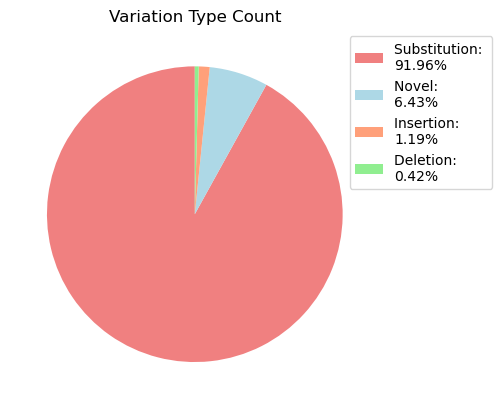

In [31]:
all_variation_nums = substitution_nums + insertion_nums + deletion_nums + novel_nums

sizes = [substitution_nums / all_variation_nums * 360, 
         novel_nums / all_variation_nums * 360,
         insertion_nums / all_variation_nums * 360, 
         deletion_nums / all_variation_nums * 360]
labels = ['Substitution: \n{}'.format("{:.2%}".format(substitution_nums / all_variation_nums)), 
          'Novel: \n{}'.format("{:.2%}".format(novel_nums / all_variation_nums)),
          'Insertion: \n{}'.format("{:.2%}".format(insertion_nums / all_variation_nums)),  
          'Deletion: \n{}'.format("{:.2%}".format(deletion_nums / all_variation_nums))]

colors = ['lightcoral', 'lightblue', 'lightsalmon', 'lightgreen']
plt.pie(sizes, startangle=90, colors=colors)

plt.legend(labels, loc='upper left', bbox_to_anchor=(0.9, 1))

plt.title('Variation Type Count')
plt.savefig('/mnt/nfs/wangd/project/paper_db/count/count-plot/Variation_Type_Count-peps-plot.svg', format='svg')

### Filter Count

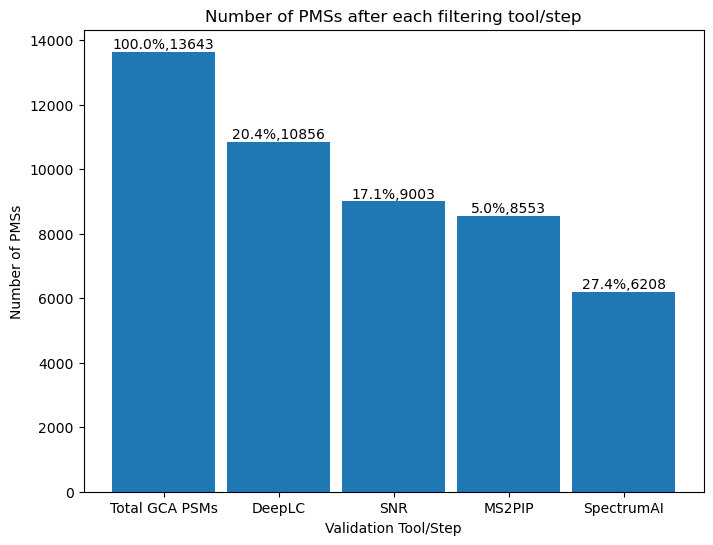

In [49]:
filter_dict = {'Total GCA PSMs': 13643, 'DeepLC': 10856, 'SNR': 9003, 'MS2PIP': 8553, 'SpectrumAI': len(passed_spectrumAI)}

labels = list(filter_dict.keys())
values = list(filter_dict.values())

plt.figure(figsize=(8,6))
bar_width = 0.9
bars = plt.bar(range(len(filter_dict)), values, width=bar_width, align='center')

plt.title('Number of PMSs after each filtering tool/step')
plt.xlabel('Validation Tool/Step')
plt.ylabel('Number of PMSs')

plt.xticks(range(len(filter_dict)), labels)


for i,bar in enumerate(bars):
    num = bar.get_height()
    if i == 0:
        s = "{},{}".format("{:.1%}".format(1),num)
        pre = num
    else:
        percentile = (pre - num)/pre 
        s = "{},{}".format("{:.1%}".format(percentile),num)
        pre = num
        
    plt.text(bar.get_x() + bar.get_width()/2, num, s, ha='center', va='bottom')

plt.savefig('/mnt/nfs/wangd/project/paper_db/count/count-plot/Filter_Count-plot.svg', format='svg')

### Protein Count

In [36]:
proteins_count = passed_spectrumAI

In [37]:
proteins_count["protein_accessions"] = proteins_count["protein_accessions"].str.split(",")

/tmp/ipykernel_380758/1312289842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proteins_count["protein_accessions"] = proteins_count["protein_accessions"].str.split(",")


In [38]:
proteins_dict = {}
for index,row in proteins_count.iterrows():
    for protein in row["protein_accessions"]:
        if proteins_dict.get(protein):
            proteins_dict[protein].add(row["sequence_x"])
        else:
            proteins_dict[protein] = {row["sequence_x"]}

In [39]:
proteins_twoPeptides_dict = {}
for key,value in proteins_dict.items():
    if len(value)>1:
        proteins_twoPeptides_dict[key] = value

In [40]:
peptides = set(proteins_count["sequence_x"].to_list())
proteins = proteins_dict.keys()
proteins_twoPeptides = proteins_twoPeptides_dict.keys()

In [41]:
print("Number of peptides: {}".format(len(peptides)))
print("Number of proteins: {}".format(len(proteins)))
print("Number of proteins with more than two peptides: {}".format(len(proteins_twoPeptides)))

Number of peptides: 3510
Number of proteins: 3071
Number of proteins with more than two peptides: 767


### Tissue Count

In [42]:
sdrf = pd.read_table("/mnt/nfs/wangd/project/10154parquet/PXD010154.sdrf.tsv")
sdrf["reference_file_name"] = sdrf['comment[data file]'].str.split(".", expand=True)[0]
file_tissue_map = sdrf[["characteristics[organism part]","source name","reference_file_name"]].set_index('reference_file_name').to_dict()
tissue_files = sdrf[["characteristics[organism part]","reference_file_name"]].drop_duplicates()["characteristics[organism part]"].value_counts()
tissue_samples = sdrf[["characteristics[organism part]","source name"]].drop_duplicates()["characteristics[organism part]"].value_counts()

In [43]:
reference_file_pep_info = {}
tissue_pep_info = {}
for index,row in proteins_count.iterrows():
    seq = row["sequence_x"]
    reference_file = row["reference_file_name"]
    tissue = file_tissue_map["characteristics[organism part]"][reference_file]
    
    if reference_file_pep_info.get(reference_file):
        reference_file_pep_info[reference_file].add(seq)
    else:
        reference_file_pep_info[reference_file]= set()
        reference_file_pep_info[reference_file].add(seq)
    
    if tissue_pep_info.get(tissue):
        tissue_pep_info[tissue].add(seq)
    else:
        tissue_pep_info[tissue]= set()
        tissue_pep_info[tissue].add(seq)

In [44]:
create_info_table(reference_file_pep_info,"reference_file","/mnt/nfs/wangd/project/paper_db/count/reference_file_peps.tsv")
create_info_table(tissue_pep_info,"Tissue","/mnt/nfs/wangd/project/paper_db/count/tissue_peps.tsv")

tissue_pep = pd.read_table("/mnt/nfs/wangd/project/paper_db/count/tissue_peps.tsv")
tissue_pep["sample_nums"] = tissue_pep["Tissue"].map(tissue_samples)
tissue_pep["files_nums"] = tissue_pep["Tissue"].map(tissue_files)
tissue_pep.sort_values("Count",ascending=False,inplace=True)
tissue_pep.to_csv("/mnt/nfs/wangd/project/paper_db/count/tissue_peps.tsv", header=1, sep="\t",index = None)

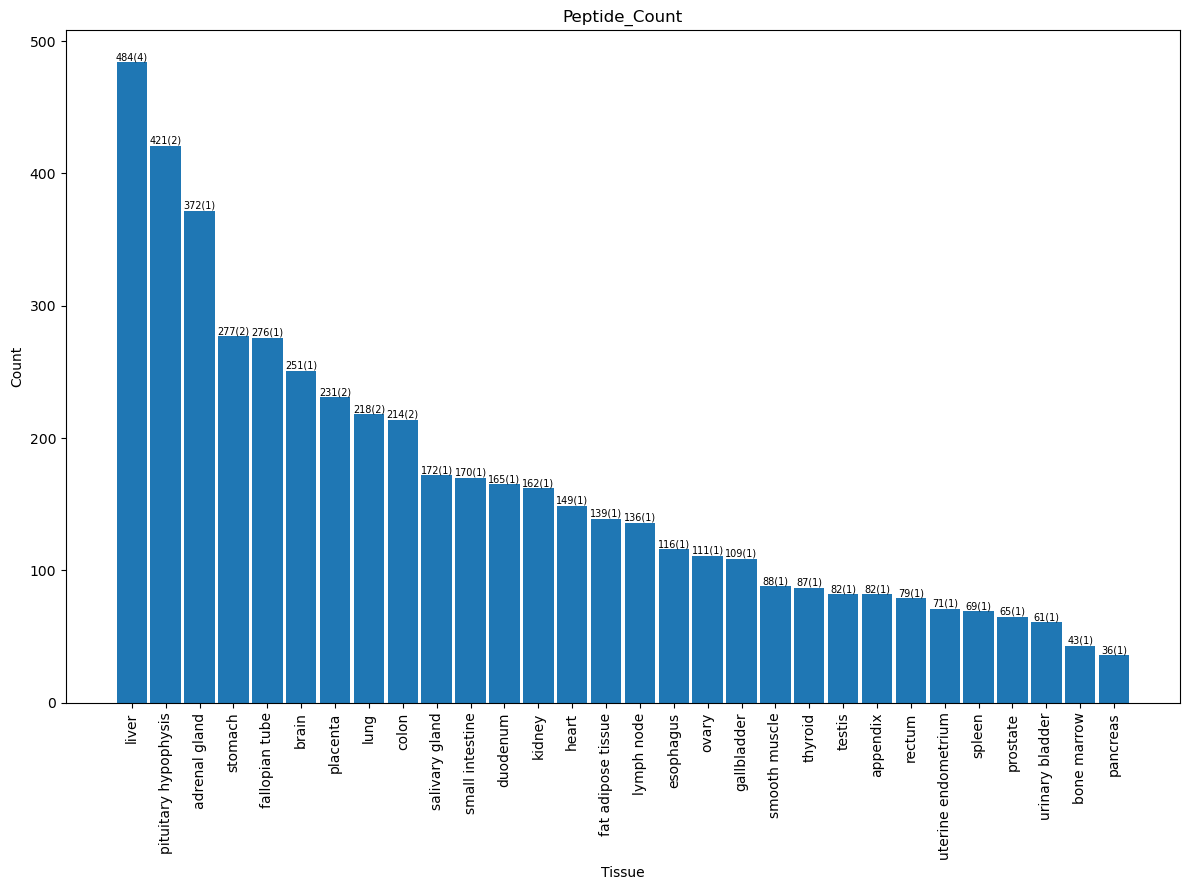

In [45]:
df = pd.read_table("/mnt/nfs/wangd/project/paper_db/count/tissue_peps.tsv")
index = df.columns[0]
df = df.sort_values('Count', ascending=False)

plt.figure(figsize=(12,9))
bar_width = 0.9
plt.bar(df[index], df['Count'], width=bar_width, align='center')
plt.xlabel(index)
plt.ylabel('Count')
plt.title('Peptide_Count')
plt.xticks(rotation='vertical')  
plt.tight_layout()  
for i, (count, num) in enumerate(zip(df['Count'], df['sample_nums'])):
    plt.text(i, count, f"{count}({num})", ha='center', va='bottom', fontsize=7)
plt.savefig('/mnt/nfs/wangd/project/paper_db/count/count-plot/' + index + '-peps-plot.svg', format='svg')

### gene_symbol Count（Contains only genes greater than 10）

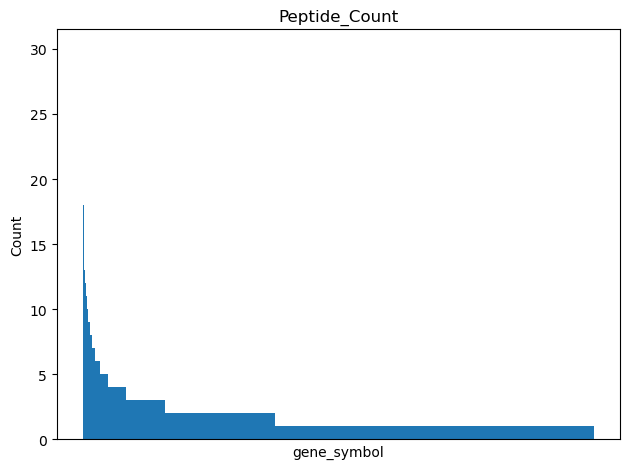

In [46]:
df = pd.read_table("/mnt/nfs/wangd/project/paper_db/count/gene_symbol_peps.tsv")
index = df.columns[0]

df = df.sort_values('Count', ascending=False)
# df = df[df["Count"]>10]

bar_width = 1
plt.bar(df[index], df['Count'],width=bar_width)
plt.xlabel(index)
plt.ylabel('Count')
plt.title('Peptide_Count')

# plt.xticks(rotation='vertical')  
plt.xticks([])
plt.tight_layout()  

# for i, count in enumerate(df['Count']):
#     plt.text(i, count, str(count), ha='center', va='bottom', fontsize=7)

plt.savefig('/mnt/nfs/wangd/project/paper_db/count/count-plot/gene_symbol-plot.svg', format='svg')

### Reference File Count

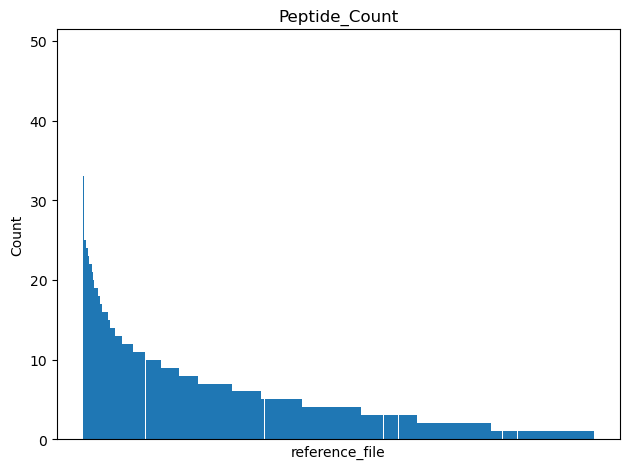

In [47]:
df = pd.read_table("/mnt/nfs/wangd/project/paper_db/count/reference_file_peps.tsv")
index = df.columns[0]

df = df.sort_values('Count', ascending=False)

bar_width = 0.99
plt.bar(df[index], df['Count'],width=bar_width)
plt.xlabel(index)
plt.ylabel('Count')
plt.title('Peptide_Count')
plt.xticks([])
plt.tight_layout()  

plt.savefig('/mnt/nfs/wangd/project/paper_db/count/count-plot/reference_file-plot.svg', format='svg')

### GCA Sample Count

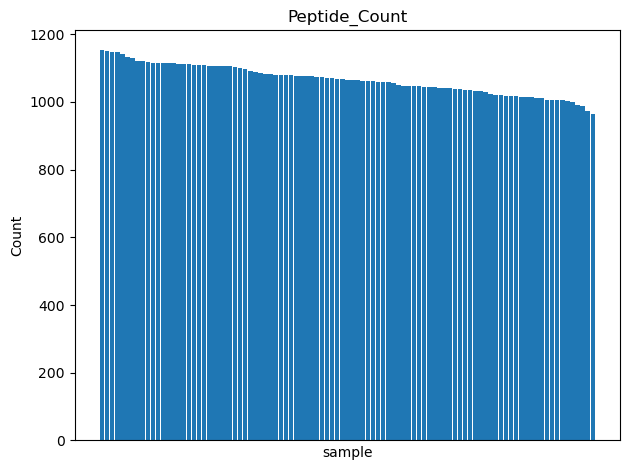

In [48]:
df = pd.read_table("/mnt/nfs/wangd/project/paper_db/count/sample_peps.tsv")
index = df.columns[0]

df = df.sort_values('Count', ascending=False)

bar_width = 0.9
plt.bar(df[index], df['Count'],width=bar_width)
plt.xlabel(index)
plt.ylabel('Count')
plt.title('Peptide_Count')
plt.xticks([])
plt.tight_layout()  

plt.savefig('/mnt/nfs/wangd/project/paper_db/count/count-plot/gca_sample-plot.svg', format='svg')